# **Sentiments Analysis on Lore Olympus comments**

**Author** : Laurène KABA

**Date**: 9 Oct 2024

**Description** : This notebook performs sentiment analysis on comments from the "Lore Olympus" comment section on Webtoon. The results are visualized using graphs and the analysis uses the VADER model for the first approach (unsupervised approach) and BERT model for the second approach (supervised approach).


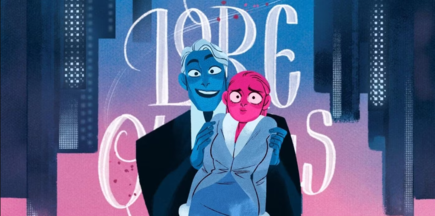

For this project we will work with the comments section on the 1st 9 chapters of Lore Olympus that we can find on the official website 'Webtoon.com'.

*Lore Olympus is actually the first Webtoon that made me buy fast pass on the app*

In [1]:
%pip install requests selenium vaderSentiment
%pip install transformers
%pip install -q google-colab-selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 15.2 MB/s eta 0:00:00


In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import regex as re
import requests
import string
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import google_colab_selenium as gs
from selenium.webdriver.common.by import By

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **DATA EXTRACTION:** Retrieving comments from webtoon *Lore Olympus* !

### Setting the driver & loading the page :



In [3]:
driver = gs.Chrome()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
def retrieve_comments_from_webtoon(np):
  """
  np: integer : number of pages to look at in order to retrieve comments from these pages.
  """
  comments_info = str()
  for i in range(np):
    url = "https://www.webtoons.com/en/romance/lore-olympus/episode-1/viewer?title_no=1320&episode_no=1"
    new_url=re.sub(r"(episode-)(\d+)|(episode_no=)(\d+)", lambda match: f"{match.group(1) or match.group(3)}{i+1}", url)
    print(new_url)
    driver.get(new_url)
    time.sleep(3)

    # you can find the class name by inspecting the HTML code of the page
    info = driver.find_elements(By.CLASS_NAME,"wcc_CommentList__list")
    if len(info)>0:
      comments_info = comments_info + info[0].text
      print(info)
      print("CHECK")
    else:
      print("NONE")
  return comments_info

In [5]:
comments = retrieve_comments_from_webtoon(9)
driver.quit()

https://www.webtoons.com/en/romance/lore-olympus/episode-1/viewer?title_no=1320&episode_no=1
[<selenium.webdriver.remote.webelement.WebElement (session="5f5ac7740a26518f6068f177b242d3a4", element="f.00B76837DD91719092AE76C45CCF91F8.d.39517A51EAD6C1F5997CBD76ADE19892.e.34")>]
CHECK
https://www.webtoons.com/en/romance/lore-olympus/episode-2/viewer?title_no=1320&episode_no=2
[<selenium.webdriver.remote.webelement.WebElement (session="5f5ac7740a26518f6068f177b242d3a4", element="f.00B76837DD91719092AE76C45CCF91F8.d.E0BD6B7C28569D97C4FA0D6ACE862E5C.e.66")>]
CHECK
https://www.webtoons.com/en/romance/lore-olympus/episode-3/viewer?title_no=1320&episode_no=3
[<selenium.webdriver.remote.webelement.WebElement (session="5f5ac7740a26518f6068f177b242d3a4", element="f.00B76837DD91719092AE76C45CCF91F8.d.7DA6EA8F4E368A7D964CCAFF64A57D1E.e.97")>]
CHECK
https://www.webtoons.com/en/romance/lore-olympus/episode-4/viewer?title_no=1320&episode_no=4
[<selenium.webdriver.remote.webelement.WebElement (session="5

## **DATA PRE-PROCESSING:** Cleaning + Pre-processing

### 1. Retrieving important informations

In [6]:
# Removing what we don't need
data = comments.replace('\nTOP','')
data=data.replace('\n',' ')
data

'셀 Mar 04, 2018 EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS SM HOPE YOU NEWCOMERS ENJOY!! Replies 96 57463 904 Maddie1137 Mar 04, 2018 The art style is mesmerizing! Can\'t wait to see where this goes, this myth has always fascinated me~ [+please like the chapters to support the author/boost it in the charts!] Replies 27 54296 674 Amalia Herrera Mar 04, 2018 I\'m from discover too.EDIT: I can\'t believe I got top comment this has never happened to me. So I guess id just like to say thank you for liking my comment. I love this myth and I can\'t wait to see the authors interpretation of this story come about😀💖🖤 Replies 17 30913 1263 justatinywifrog Mar 04, 2018 HEY YEAH HI IM A GREEK NERD AND I LOVE THIS MORE THAN ZEUS LIKES TO FUCK EVERYTHING THAT MOVES KTHNXSBAI Replies 30 1817 24 Mikan200 Mar 04, 2018 Hades\' phone: Apple=Pomegranate lol Replies 9 943 6 Anna Rukat Jul 01, 2018 this satisfies my inner mythology nerd in a strange way. here, have some trivia: Minthe was a naiad, a kind 

In [7]:
# Catching informations we want
pattern = re.compile(r'(\w{3} \d{2}, \d{4}) (.*?) (Replies \d+|Reply\s?\d?) (\d+) (\d+)', re.DOTALL)
matches = pattern.findall(data)

In [8]:
formated_list= list()
comments_only= list()
for match in matches:
    date, comment, replies, like, dislike = match
    formated_list.append({
        'Date': date,
        'Comment': comment.strip(),
        'Like': int(like),
        'Dislike': int(dislike)
    })
    comments_only.append({
        'Comment': comment.strip()
    })

In [9]:
#Saving data into csv files
comments_df=pd.DataFrame(formated_list)
comments_only_df=pd.DataFrame(comments_only)
comments_df.to_csv('Lore_Olympus_comments.csv', index=False)
comments_only_df.to_csv('Lore_Olympus_comments_only.csv', index=False)

In [10]:
comments_df.head()

,Date,Comment,Like,Dislike
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57463,904
1,"Mar 04, 2018",The art style is mesmerizing! Can't wait to se...,54296,674
2,"Mar 04, 2018",I'm from discover too.EDIT: I can't believe I ...,30913,1263
3,"Mar 04, 2018",HEY YEAH HI IM A GREEK NERD AND I LOVE THIS MO...,1817,24
4,"Mar 04, 2018",Hades' phone: Apple=Pomegranate lol,943,6


#### Quick EDA

In [11]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     201 non-null    object
 1   Comment  201 non-null    object
 2   Like     201 non-null    int64 
 3   Dislike  201 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.4+ KB


**Like and Dislike distribution:**

,Like,Dislike
count,201.000000,201.000000
mean,12647.099502,67.726368
std,36247.101372,199.417476
min,28.000000,0.000000
25%,165.000000,1.000000
50%,383.000000,3.000000
75%,1498.000000,7.000000
max,190866.000000,1263.000000


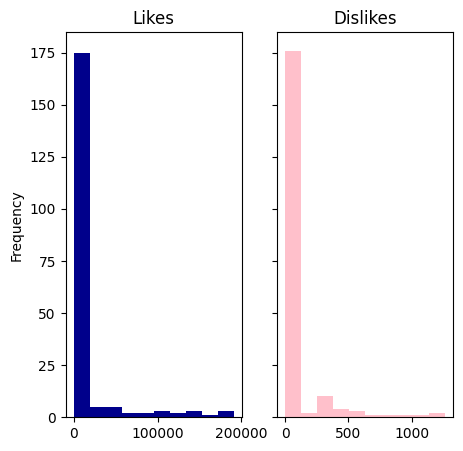

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(5,5), sharey=True)

comments_df["Like"].plot(kind='hist',color='darkblue', ax=axes[0])
axes[0].set_title("Likes")

comments_df["Dislike"].plot(kind='hist',color='pink', ax=axes[1])
axes[1].set_title("Dislikes")

comments_df[['Like','Dislike']].describe()

**Length and word count of comments distributions:**

,Comment
count,201.000000
mean,100.313433
std,82.256041
min,18.000000
25%,49.000000
50%,75.000000
75%,125.000000
max,436.000000


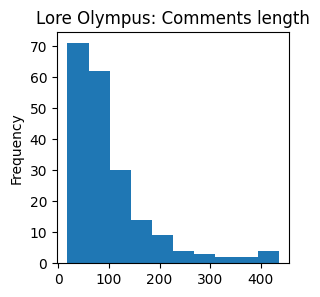

In [13]:
comments_df['Comment'].str.len().plot(kind='hist', title='Lore Olympus: Comments length', figsize=(3,3))
comments_df['Comment'].str.len().describe()

,Comment
count,201.000000
mean,18.447761
std,15.087031
min,1.000000
25%,9.000000
50%,14.000000
75%,24.000000
max,88.000000


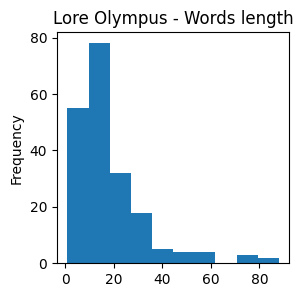

In [14]:
comments_df['Comment'].str.split().apply(len).plot(kind='hist', title='Lore Olympus - Words length', figsize=(3,3))
comments_df['Comment'].str.split().apply(len).describe()

### 2. NLP data pipeline for Sentiment Analysis



In [15]:
cdf1=comments_df.copy()
cdf1.head()

,Date,Comment,Like,Dislike
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57463,904
1,"Mar 04, 2018",The art style is mesmerizing! Can't wait to se...,54296,674
2,"Mar 04, 2018",I'm from discover too.EDIT: I can't believe I ...,30913,1263
3,"Mar 04, 2018",HEY YEAH HI IM A GREEK NERD AND I LOVE THIS MO...,1817,24
4,"Mar 04, 2018",Hades' phone: Apple=Pomegranate lol,943,6


DATA PIPELINE

In [16]:
# Remove punctuation & emojis
def remove_punctuation_emojis(text):
  translation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  cleaned_text = text.translate(translation_table)
  punctuationfree = ' '.join(cleaned_text.split())
  return punctuationfree

def remove_emojis(text):
    # Regular expression to match emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FAFF"  # Chess Symbols
        "\U00002702-\U000027B0"  # Miscellaneous Symbols
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [17]:
# Tokenization + Removing stopwords
stopwords = nltk.corpus.stopwords.words('english')

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(list_com):
    output= [text for text in list_com if text not in stopwords]
    output = " ".join(output)
    return output

In [18]:
# Stemming
def stemming(words):
  # Initialize the stemmer
  stemmer = PorterStemmer()
  stemmed_words = stemmer.stem(words)
  return stemmed_words

In [19]:
# FULL PIPELINE
def data_processing_pipeline(df):
  # remove punctuation & emojis
  df['Clean_comment'] = df['Comment'].apply(lambda x:remove_emojis(remove_punctuation_emojis(x)))

  # Lowercases
  df['Comment_Lower'] = df['Clean_comment'].apply(lambda x: x.lower())

  # Tokenization & stopwords
  df['Summary_Tokenized'] = df['Comment_Lower'].apply(lambda x: tokenization(x))
  df['Comment_no_stopwords'] = df['Summary_Tokenized'].apply(lambda x: remove_stopwords(x))

  # stemming:
  df['Comments_stem'] = df['Comment_no_stopwords'].apply(lambda x: stemming(x))

data_processing_pipeline(cdf1)
cdf1.head(2)

,Date,Comment,Like,Dislike,Clean_comment,Comment_Lower,Summary_Tokenized,Comment_no_stopwords,Comments_stem
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57463,904,EYYY ANYONE HERE FROM DISCOVER I LOVE THIS SM ...,eyyy anyone here from discover i love this sm ...,"[eyyy, anyone, here, from, discover, i, love, ...",eyyy anyone discover love sm hope newcomers enjoy,eyyy anyone discover love sm hope newcomers enjoy
1,"Mar 04, 2018",The art style is mesmerizing! Can't wait to se...,54296,674,The art style is mesmerizing Can t wait to see...,the art style is mesmerizing can t wait to see...,"[the, art, style, is, mesmerizing, can, t, wai...",art style mesmerizing wait see goes myth alway...,art style mesmerizing wait see goes myth alway...


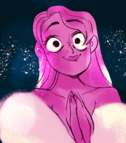

Now we got something cleaner to work with !

## **MODELING:** Sentiment Analysis


**(A) VADER model: Sentiment scoring:**

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [21]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Sentiment score
def get_sentiment(words):
  return analyzer.polarity_scores(words)['compound']

# Sentiment category
def get_category(score):
  if score >= 0.05:
    return 'pos'
  elif score <=-0.05:
    return 'neg'
  else:
    return 'neu'

cdf1["Sentiment score"]=cdf1["Comments_stem"].apply(lambda x:get_sentiment(x))
cdf1["Sentiment category"]=cdf1["Sentiment score"].apply(lambda x:get_category(x))

**B) Results:**

In [22]:
cdf1.head(2)

,Date,Comment,Like,Dislike,Clean_comment,Comment_Lower,Summary_Tokenized,Comment_no_stopwords,Comments_stem,Sentiment score,Sentiment category
0,"Mar 04, 2018",EYYY ANYONE HERE FROM DISCOVER??? I LOVE THIS ...,57463,904,EYYY ANYONE HERE FROM DISCOVER I LOVE THIS SM ...,eyyy anyone here from discover i love this sm ...,"[eyyy, anyone, here, from, discover, i, love, ...",eyyy anyone discover love sm hope newcomers enjoy,eyyy anyone discover love sm hope newcomers enjoy,0.8834,pos
1,"Mar 04, 2018",The art style is mesmerizing! Can't wait to se...,54296,674,The art style is mesmerizing Can t wait to see...,the art style is mesmerizing can t wait to see...,"[the, art, style, is, mesmerizing, can, t, wai...",art style mesmerizing wait see goes myth alway...,art style mesmerizing wait see goes myth alway...,0.9062,pos


In [23]:
cdf1["Sentiment category"].value_counts()

,count
Sentiment category,
pos,89
neu,67
neg,45


In [24]:
# Saving the results
cdf1.to_csv('Lore_Olympus_labeled_dataset2.csv', index=False)

Now that we have our data labeled, we'll see interesting insights in Sentiment Analysis pt.2 !

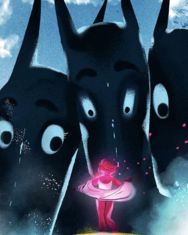